# Reproducing the figures from my master thesis

## Thesis title: Pre-supernova Evolution of Rapidly Rotating Massive Stars at Low Metallicity

## Author: David Ramon Aguilera Dena

## University of Bonn

## Submission date: September 2017

This Jupyter notebook will reproduce all the figures in my master thesis, as well as some additional figures I needed to analyse and understand my data. It works using numpy for operations, matplotlib for figures, and pandas for data handling. The figures are based on MESA models of stellar evolution of rotating single stars. The models used originally were made in MESA version 8845.

The text of the thesis can be found here: https://astro.uni-bonn.de/~nlanger/thesis/david_master.pdf

This Jupyter notebook is structured as follows:

# I. Importing necessary packages

# II. Function declarations

II.i. HR_diagram

II.ii. Add_column

# III. Loading the data

# IV. Making the figures

In [1]:
################# I. Importing necessary packages #################

import numpy as np                       #for handling arrays and making operations
import matplotlib.pyplot as plt          #for making figures
import os                                #I use os.listdir to read the files in a folder, like ls
                                         #and os.path.exists() to check if files exist
import re                                #Regular Expressions library. Contains "split"
import pandas as pd                      #for handling data files

In [259]:
#################### II. Function declarations ####################

## 1. Load_data ##
## This function... is not finished
#i want to add metadata 

def Load_history_data_grid(path,
                          columns =  ['star_age', 'model_number', 'star_mass',
                                      'log_abs_mdot', 'log_R', 'log_center_T',
                                      'luminosity', 'log_Teff', 'log_Lneu', 'log_L',
                                      'log_Lnuc', 'center_h1','center_he4', 'center_c12',
                                      'center_n14', 'center_o16', 'surface_h1',
                                      'surface_he4', 'surface_li7', 'surface_c12',
                                      'surface_n14', 'surface_o16','surface_ne20',
                                      'surface_mg24', 'surface_al27', 'total_mass_h1',
                                      'total_mass_he4','kh_timescale', 'surf_avg_j_rot',
                                      'surf_avg_omega_div_omega_crit'],
                          suffix='/LOGS/history.data',
                          selection='all'):
    
    if isinstance(selection,list):
        model_list = selection
        print('Total number of selected models: ', len(model_list))
    elif selection=='all':
        model_list = sorted(os.listdir(path))
        print('Total number of subdirectories in directory: ', len(model_list))
    else:
        print('Something went wrong in your selection. Options: "all" or a list containing the names of model directories.')
        print('Going with the default value (all)')
        model_list = sorted(os.listdir(path))
        print('Total number of subdirectories in directory: ', len(model_list))

    model_data = {}
    
    progress_count = 0
    for model in model_list:
        progress_count+=1
        if progress_count%10==0:
            print('Progress: ', "{:10.1f}".format(100.*float(progress_count)/float(len(model_list))), '%')
        model_path = path + model + suffix
        if os.path.exists(model_path):
            mass = model.split('_')[0]
            rot_vel = model.split('_')[1]
            df_model = pd.read_table(model_path, header=4, sep='\s+',usecols=columns)
            df_model = cut_crazy_points_L(df_model)
            #metadata
            df_model.initial_mass = float(mass)
            df_model.initial_vel = float(rot_vel)
            df_model.relax_point = find_relax_point(df_model[['log_L','log_Lnuc']])
            model_data[model] = df_model
        else:
            print('There is no history file for the following model: ',model)

    print('Models loaded into dictionary')
    return model_data

def Load_profile_data(path,
                          columns =  ['zone','logT','logRho','logP','logR','luminosity',  
                                      'eps_grav','entropy','mass','h1','he3','he4',  
                                      'c12','n14','o16','ne20','mg24','pp','cno',  
                                      'tri_alfa','burn_c','burn_n','burn_o',  
                                      'burn_ne','burn_na','burn_mg','burn_si',  
                                      'burn_s','burn_ar','burn_ca','burn_ti',  
                                      'burn_cr','burn_fe','c12_c12','c12_o16',  
                                      'o16_o16','pnhe4','photo','other'],
                          folder='LOGS/',
                          profile_numbers = 'all'):
    if profile_numbers=='all':        
        file_list = os.listdir(path+folder)
        profile_list = [file for file in file_list if file[0:7]=='profile' and file.split('.')[1]=='data']
        profile_list = sorted(profile_list, key=lambda x: int(x.split('.')[0][7:]))
        print('The total number of profiles is ', len(profile_list))
        
        profile_data = {}

        for profile in profile_list:
            profile_path = path + folder + profile
            df_profile = pd.read_table(profile_path, header=4, sep='\s+',usecols=columns)
            df_header = pd.read_table(profile_path,header=1,nrows=1)
            #metadata
            header_cols = ['initial_mass','model_number']
            df_header = pd.read_table(profile_path,header=1,nrows=1,sep='\s+',usecols=header_cols)

            df_profile.initial_mass = df_header['initial_mass'].values[0]
            df_profile.model_number = df_header['model_number'].values[0]
            key = profile.split('.')[0]
            profile_data[key] = df_profile

        print('Profile(s) loaded into dictionary')
        return profile_data

        
    elif isinstance(profile_numbers,list):
        if isinstance(profile_numbers[0],int):
            profile_list = ['profile'+str(num)+'.data' for num in profile_numbers]
        elif isinstance(profile_numbers[0],str):
            profile_list = profile_numbers
        else:
            print('Something went wrong with the profile_numbers input, going back to default (all)')
            file_list = os.listdir(path+folder)
            profile_list = [file for file in file_list if file[0:7]=='profile' and file.split('.')[1]=='data']
            profile_list = sorted(profile_list, key=lambda x: int(x.split('.')[0][7:]))
            print('The total number of profiles is ', len(profile_list))
        
        profile_data = {}

        for profile in profile_list:
            profile_path = path + folder + profile
            df_profile = pd.read_table(profile_path, header=4, sep='\s+',usecols=columns)
            df_header = pd.read_table(profile_path,header=1,nrows=1)
            #metadata
            header_cols = ['initial_mass','model_number']
            df_header = pd.read_table(profile_path,header=1,nrows=1,sep='\s+',usecols=header_cols)

            df_profile.initial_mass = df_header['initial_mass'].values[0]
            df_profile.model_number = df_header['model_number'].values[0]
            key = profile.split('.')[0]
            profile_data[key] = df_profile

        print('Profile(s) loaded into dictionary')
        return profile_data
    elif isinstance(profile_numbers,int):
        profile_path = path + folder + 'profile'+str(profile_numbers) + '.data'
        df_profile = pd.read_table(profile_path, header=4, sep='\s+',usecols=columns)
        df_header = pd.read_table(profile_path,header=1,nrows=1)
        #metadata
        header_cols = ['initial_mass','model_number']
        df_header = pd.read_table(profile_path,header=1,nrows=1,sep='\s+',usecols=header_cols)

        df_profile.initial_mass = df_header['initial_mass'].values[0]
        df_profile.model_number = df_header['model_number'].values[0]
        print('1 profile loaded into pandas dataframe')
        return df_profile

    else:
        print('Something went wrong with the profile_numbers input, going back to default (all)')
        file_list = os.listdir(path+folder)
        profile_list = [file for file in file_list if file[0:7]=='profile' and file.split('.')[1]=='data']
        profile_list = sorted(profile_list, key=lambda x: int(x.split('.')[0][7:]))
        print('The total number of profiles is ', len(profile_list))
        file_list = os.listdir(path+folder)
        profile_list = [file for file in file_list if file[0:7]=='profile' and file.split('.')[1]=='data']
        profile_list = sorted(profile_list, key=lambda x: int(x.split('.')[0][7:]))
        print('The total number of profiles is ', len(profile_list))
        
        profile_data = {}

        for profile in profile_list:
            profile_path = path + folder + profile
            df_profile = pd.read_table(profile_path, header=4, sep='\s+',usecols=columns)
            df_header = pd.read_table(profile_path,header=1,nrows=1)
            #metadata
            header_cols = ['initial_mass','model_number']
            df_header = pd.read_table(profile_path,header=1,nrows=1,sep='\s+',usecols=header_cols)

            df_profile.initial_mass = df_header['initial_mass'].values[0]
            df_profile.model_number = df_header['model_number'].values[0]
            key = profile.split('.')[0]
            profile_data[key] = df_profile

        print('Profile(s) loaded into dictionary')
        return profile_data

# 1. Add_column ##
# This function is not finished but should add columns to model dataframes

# def Add_column(models,column):
#     if isinstance(models, pd.DataFrame):
#         df_temp = 
#     elif isinstance(models, dict):
#     else:
#         print('The input of this function should be either a dictionary containing all the data')
#         print('in the form of pandas dataframes, or a single pandas dataframe.')
#         return

# this function should find the model number where the stellar model is at the zams (to make sure that's where zams properties like omega_div_omega_crit_init are measured)
def find_relax_point(df):
    for i in range(0,len(df['log_L'].values)):
        if np.log10(abs(df['log_Lnuc'].values[i] / df['log_L'].values[i])) > 0.005:
            break
    return i+2

def cut_crazy_points_L(df):
    cut = -1
    for i in range(len(df['log_L'].values)-1,len(df['log_L'].values)-51,-1):
        delta = abs(df['log_L'].values[i] - df['log_L'].values[i-1])
        if delta>0.05:
            cut = df['model_number'][i]
    if cut!=-1:
        df = df[df['model_number']<cut]
    return df

def landmarks(df):
    import math
    model_numbers = []
    closest_profiles = []
    labels = ['during He burning','at core He depletion','at core C depletion']
    
    num_heburn = df[df['center_he4']<0.997][df['center_h1']<1e-5]['model_number'].values[0]
    model_numbers.append(num_heburn)
    
    C_max = max(df['center_c12'].values)
    
    num_hedepl = df[df['center_he4']<0.01*C_max][df['center_h1']<1e-5]['model_number'].values[0]
    model_numbers.append(num_hedepl)
    
    num_cdepl = df[df['center_c12']<0.001][df['log_center_T']>8.4]['model_number'].values[0]
    model_numbers.append(num_cdepl)
    
    return model_numbers,labels

def closest_next_profiles(path,
                          nums,
                          folder='LOGS/'):
    folder = 'LOGS/'
    index = path + folder + 'profiles.index'
    df = pd.read_table(index,sep='\s+',skiprows=1,header=None,names=['modelnum','prio','profnum'])
    if isinstance(nums,int):
        cnp = int(df[df['modelnum']>=nums]['profnum'].values[0])
        return cnp
    elif isinstance(nums,list):
        cnps = []
        for num in nums:
            cnp = int(df[df['modelnum']>=num]['profnum'].values[0])
            cnps.append(cnp)
        return cnps
    else:
        print('Something went wrong with the input data.')
        return


#colors = ["#017351", "#03c383", "#aad962", "#fbbf45", "#ef6a32", "#ed0345","#a12a5e",  "#710162", "#110141"]
def HR_diagram(model,
               title='HRD of model',
               x_lowerlim = 1e3,
               x_upperlim = 1e6,
               y_lowerlim = 1e3,
               y_upperlim = 1e7,
               lw = 3,
               color = '#ef6a32',
               box_loc = 'out',   #location of the label box. options are 'out' or 'in'
               save=False,
               filename = './figure.pdf'):
    cols = ['log_Teff','log_L','model_number','log_Lnuc']
    if isinstance(model,str):
        infile = model + '/LOGS/history.data'
        df = pd.read_table(infile, header=4, sep='\s+',usecols=cols)
        relax_point = find_relax_point(df)
        df = df[df['model_number']>=relax_point]
    elif isinstance(model, pd.DataFrame):
        print('You provided a pandas dataframe containing the model')
        df = model[cols]
        relax_point = find_relax_point(df)
        df = df[df['model_number']>=relax_point]
    elif isinstance(model,dict):
        if (title=='HRDs of model'):
            title = 'HRDs of models in grid'
        fig = plt.figure()
        ax = fig.add_subplot(111)
        ax.set_xlabel('Effective Temperature [K]')
        ax.set_ylabel('Luminosity [L$_{\odot}$]')
        fig.set_size_inches([5,5])
        ax.set_xlim(x_lowerlim,x_upperlim)
        ax.set_ylim(y_lowerlim,y_upperlim)
        ax.invert_xaxis()
        if isinstance(color,str) and color in plt.colormaps():
            color = iter(plt.get_cmap(color)(np.linspace(0,1,len(model.keys()))))
        elif isinstance(color,list) and len(color)==len(model.keys()):
            color = iter(color)
        elif color=='#ef6a32':
            color = iter(plt.cm.rainbow(np.linspace(0,1,len(model.keys()))))
        else:
            try:
                next(color)
            except:
                print('Something went wrong when you chose the colors for the HRD tracks.')
                print('Please either input a list with as many color codes as there are models')
                print('in the dictionary, the name of a matplotlib colormap, or an iterable object')
                print('(for example: color=iter(plt.cm.rainbow(np.linspace(0,1,len(model.keys()))))).')
                print('Going with the default "rainbow" colormap.')
                color=iter(plt.cm.rainbow(np.linspace(0,1,len(model.keys()))))
        plt.title(title)
        for key, df in model.items():
            c=next(color)
            x = np.power(10.0,df[df['model_number']>=df.relax_point][cols[0]])
            y = np.power(10.0,df[df['model_number']>=df.relax_point][cols[1]])
            if key.split('_')[0][-1]=='0':
                mass_label = str(int(float(key.split('_')[0])))
            else:
                mass_label = str(float(key.split('_')[0]))
            label = mass_label + r' M$_{\odot}$, ' + str(int(float(key.split('_')[1]))) + ' km/s'
            image = ax.loglog(x,y,linewidth=lw,label=label,c=c)
        if box_loc=='out':
            ax.legend(bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0.,frameon=False,fontsize=8)
            #ax.legend()
        elif box_loc=='in':
            ax.legend(loc='best', borderaxespad=0.,frameon=False,fontsize=8)
        else:
            print('Wrong input for box_loc. Options are "in" or "out".')
            ax.legend(bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0.,frameon=False,fontsize=8)
        return image
    fig = plt.figure()
    ax = fig.add_subplot(111)
    ax.set_xlabel('Effective Temperature [K]')
    ax.set_ylabel('Luminosity [L$_{\odot}$]')
    fig.set_size_inches([5,5])
    plt.title(title)
    ax.set_xlim(x_lowerlim,x_upperlim)
    ax.set_ylim(y_lowerlim,y_upperlim)
    image = ax.loglog(np.power(10,df[cols[0]]),np.power(10,df[cols[1]]),linewidth=lw,c=color)
    if save:
         plt.savefig(filename, bbox_inches='tight')
    return image

def chem_profile(df,
                 elements = ['h1', 'he4', 'c12', 'n14', 'o16', 'ne20',
                             'mg24', 'si28', 's32', 'ar36', 'ca40', 'ti44', 
                             'cr48', 'cr56', 'fe52', 'fe54', 'fe56', 'ni56'],
                title = '',
                save=False,
                filename='chemical_profile.pdf'):
    x = df['mass']
    initial_mass = df.initial_mass
    
    fig = plt.figure()
    ax = fig.add_subplot(111)

    plt.rc('xtick', direction='in')
    plt.rc('xtick', color='black')
    plt.rc('ytick', direction='in')
    #ax.set_aspect('equal')
    ax.set_xlabel('Mass coordinate [M$_{\odot}$]')
    ax.set_ylabel('Mass fraction')
    fig.set_size_inches([5,5])
    ncolors = len(elements)
    color=iter(plt.cm.Set1(np.linspace(0,1,ncolors)))
    for element in elements:
        c=next(color)
        image = ax.semilogy(x,df[element],label=element,c=c,linewidth=3)
    
    ax.set_xlim(0,initial_mass)
    ax.set_ylim(1e-3,1.1)
    ax.legend(bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0.,frameon=False)
    plt.tick_params(labeltop=False, labelright=False)
    ax.yaxis.set_ticks_position('both')
    ax.xaxis.set_ticks_position('both')
    if title!='':
        plt.title(title)
    if save:
        plt.savefig(filename, bbox_inches='tight')

    return image




In [100]:
path = "/path/to/models/"
model_data = Load_history_data_grid(path)

Total number of subdirectories in directory:  114
There is no history file for the following model:  005.0_600.0
Progress:         8.8 %
Progress:        17.5 %
There is no history file for the following model:  007.0_600.0
Progress:        26.3 %
There is no history file for the following model:  009.0_000.0
There is no history file for the following model:  009.0_200.0
Progress:        35.1 %
Progress:        43.9 %
There is no history file for the following model:  015.0_200.0
There is no history file for the following model:  015.0_300.0
There is no history file for the following model:  015.0_350.0
Progress:        52.6 %
There is no history file for the following model:  017.0_400.0
Progress:        61.4 %
Progress:        70.2 %
Progress:        78.9 %
Progress:        87.7 %
There is no history file for the following model:  100.0_000.0
Progress:        96.5 %
There is no history file for the following model:  lower.tar.gz
There is no history file for the following model:  lowe

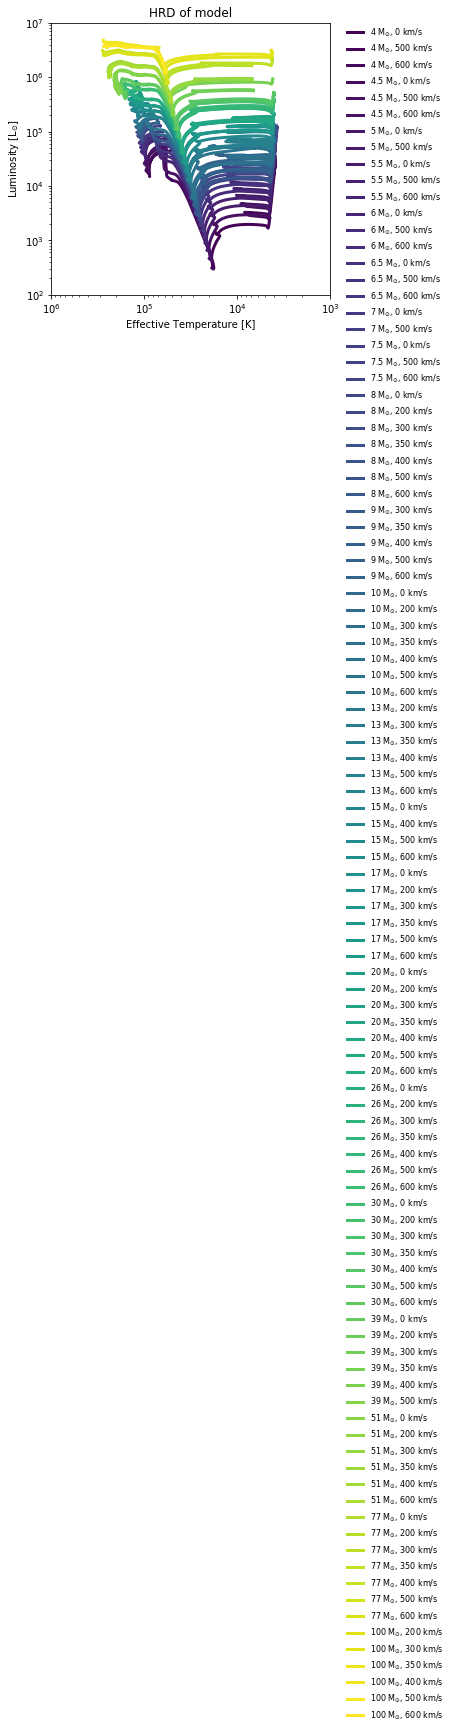

In [101]:
HR_diagram(model_data,color='viridis',y_lowerlim = 1e2,y_upperlim = 1e7)

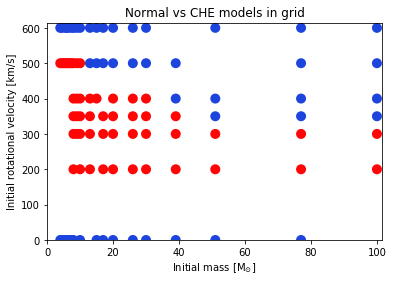

In [35]:
# Figure 3.2
# Note: This figure is an attempt to replicate Figure 3 from Szécsi et al. 2015

fig1 = plt.figure()
ax1 = fig1.add_subplot(111)

for key, model in model_data.items():
    if model['log_Teff'].values[0]>model['log_Teff'].values[-1]:
        c ='#ff0505'
    else:
        c='#1d44dd'
    ax1.scatter(float(key.split('_')[0]),float(key.split('_')[1]),c=c,edgecolors='none', s=100)



ax1.set_ylabel('Initial rotational velocity [km/s]')
ax1.set_xlabel('Initial mass [M$_{\odot}]$')
ax1.set_xlim(0,101.5)
ax1.set_ylim(0,615)

plt.title('Normal vs CHE models in grid')
plt.show()


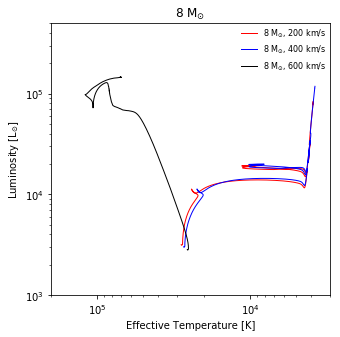

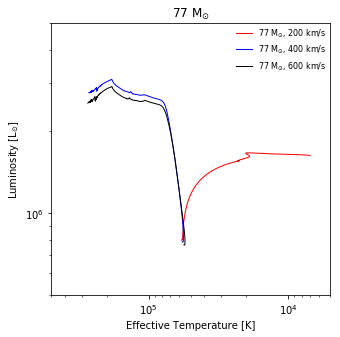

In [68]:
# Figure 3.3
# Note: This figure is an attempt to replicate Figure 3 from Szécsi et al. 2015

names_8M = ['008.0_600.0','008.0_400.0','008.0_200.0']
models_8M = {key:value for key, value in model_data.items() if key in names_8M}

HR_diagram(models_8M, title=r'8 M$_{\odot}}$',
           color=['red','blue','black'],lw=1,x_lowerlim=3e3,x_upperlim=2e5,y_lowerlim=1e3,y_upperlim=5e5,box_loc='in')

names_77M = ['077.0_600.0','077.0_400.0','077.0_200.0']
models_77M = {key:value for key, value in model_data.items() if key in names_77M}

HR_diagram(models_77M,title=r'77 M$_{\odot}}$',
           color=['red','blue','black'],lw=1,x_lowerlim=5e3,x_upperlim=5e5,y_lowerlim=5e5,y_upperlim=5e6,box_loc='in')

/usr/lib/python3/dist-packages/ipykernel_launcher.py:7: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  import sys
/usr/lib/python3/dist-packages/ipykernel_launcher.py:12: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  if sys.path[0] == '':
/usr/lib/python3/dist-packages/ipykernel_launcher.py:15: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  from ipykernel import kernelapp as app


1 profile loaded into pandas dataframe


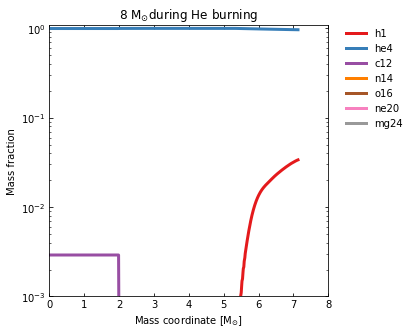

1 profile loaded into pandas dataframe


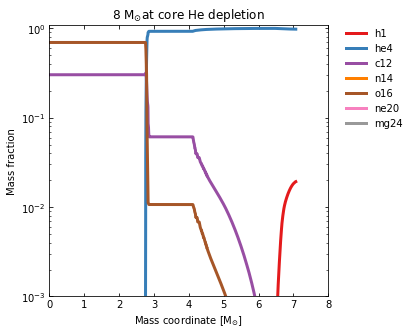

1 profile loaded into pandas dataframe


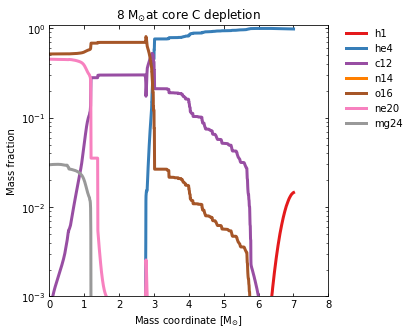

1 profile loaded into pandas dataframe


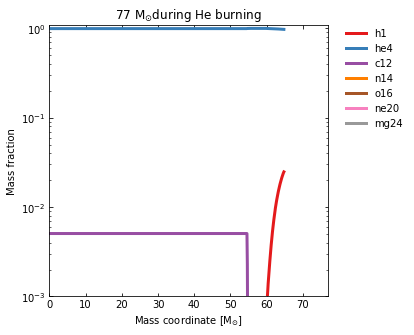

1 profile loaded into pandas dataframe


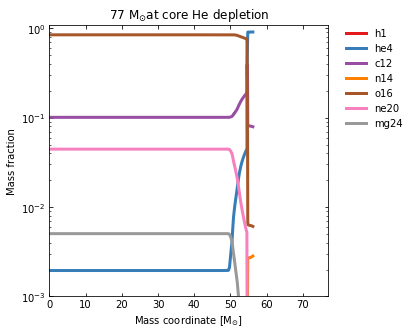

1 profile loaded into pandas dataframe


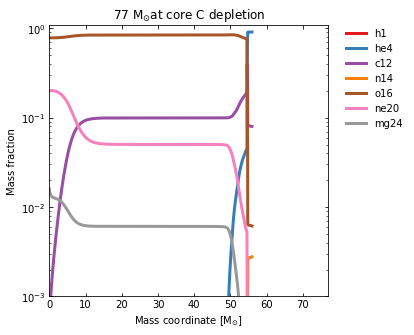

In [293]:
# Figure 3.4

examples = ['008.0_600.0','077.0_600.0']

for ex in examples:
    df = model_data[ex]
    nums,labs = landmarks(df)
    profs = closest_next_profiles(path+ex+'/',nums)

    for lab,prof in zip(labs,profs):
        profile = Load_profile_data(path+ex+'/',profile_numbers=prof)
        im = chem_profile(profile,elements=elements,title=str(int(profile.initial_mass)) + r' M$_{\odot}$' +lab)
        plt.show()

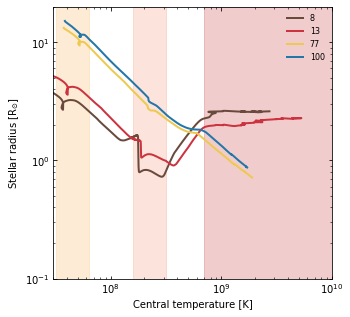

In [305]:
# Figure 3.6

fig1 = plt.figure()
ax1 = fig1.add_subplot(111)
models = ['005.0_600.0','008.0_600.0','013.0_600.0','039.0_600.0','077.0_600.0','100.0_600.0']
c = ["#00A0B0", "#6A4A3C", "#CC333F", "#EB6841", "#EDC951", "#2377a8"]
for model,color in zip(models,c):
    if model in model_data.keys():
        x = model_data[model]['log_center_T']
        y = model_data[model]['log_R']
        label = str(int(model_data[model].initial_mass))
        ax1.loglog(np.power(10.0,x), np.power(10.0,y),label=label,linewidth=2, c=color)

ax1.set_xlabel('Central temperature [K]')
ax1.set_ylabel('Stellar radius [R$_{\odot}$]')
ax1.set_xlim(3e7,1e10)
ax1.set_ylim(1e-1, 2e1)
ax1.legend(loc='best',frameon=False,prop={'size':8})

fig1.set_size_inches([5,5])
plt.axvspan(10**7.5, 10**7.8, color='#fdcd96', alpha=0.4)
plt.axvspan(10**8.2, 10**8.5, color='#f4764f', alpha=0.2)
plt.axvspan(7*10**8, 10**10, color='#b80604', alpha=0.2)

plt.tick_params(labeltop=False, labelright=False)
ax1.yaxis.set_ticks_position('both')
ax1.xaxis.set_ticks_position('both')

plt.show()